In [4]:
#installing packages
!pip install opencv-python scikit-learn --quiet

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from PIL import Image
import cv2
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [13]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import os

#loading image
def safe_loader(path):
    try:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")
    except Exception as e:
        print(f"❌ Skipping corrupted image: {path}")
        return None  # Will be skipped by custom dataset class

#neglect the broken imgs
class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        while True:
            path, target = self.samples[index]
            image = safe_loader(path)
            if image is not None:
                if self.transform is not None:
                    image = self.transform(image)
                return image, target
            else:
                index = (index + 1) % len(self.samples)  # Try next image

#transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

data_dir = '/content/drive/MyDrive/dataset/data/chest_xray/chest_xray'


#dataset loading
train_set = SafeImageFolder(os.path.join(data_dir, '/content/drive/MyDrive/dataset/data/chest_xray/chest_xray/test'), transform=transform)
val_set   = SafeImageFolder(os.path.join(data_dir, '/content/drive/MyDrive/dataset/data/chest_xray/chest_xray/val'), transform=transform)
test_set  = SafeImageFolder(os.path.join(data_dir, '/content/drive/MyDrive/dataset/data/chest_xray/chest_xray/test'), transform=transform)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


In [14]:
# loading resnet model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
# model training
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

100%|██████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch [1/20], Loss: 0.1027


100%|██████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch [2/20], Loss: 0.0374


100%|██████████| 39/39 [00:11<00:00,  3.49it/s]


Epoch [3/20], Loss: 0.0307


100%|██████████| 39/39 [00:11<00:00,  3.54it/s]


Epoch [4/20], Loss: 0.0599


100%|██████████| 39/39 [00:11<00:00,  3.42it/s]


Epoch [5/20], Loss: 0.0603


100%|██████████| 39/39 [00:10<00:00,  3.63it/s]


Epoch [6/20], Loss: 0.0425


100%|██████████| 39/39 [00:11<00:00,  3.33it/s]


Epoch [7/20], Loss: 0.0417


100%|██████████| 39/39 [00:12<00:00,  3.22it/s]


Epoch [8/20], Loss: 0.0600


100%|██████████| 39/39 [00:11<00:00,  3.49it/s]


Epoch [9/20], Loss: 0.0786


100%|██████████| 39/39 [00:12<00:00,  3.21it/s]


Epoch [10/20], Loss: 0.0979


100%|██████████| 39/39 [00:11<00:00,  3.47it/s]


Epoch [11/20], Loss: 0.1750


100%|██████████| 39/39 [00:10<00:00,  3.67it/s]


Epoch [12/20], Loss: 0.0477


100%|██████████| 39/39 [00:10<00:00,  3.81it/s]


Epoch [13/20], Loss: 0.0444


100%|██████████| 39/39 [00:11<00:00,  3.51it/s]


Epoch [14/20], Loss: 0.0546


100%|██████████| 39/39 [00:11<00:00,  3.50it/s]


Epoch [15/20], Loss: 0.0203


100%|██████████| 39/39 [00:11<00:00,  3.40it/s]


Epoch [16/20], Loss: 0.0143


100%|██████████| 39/39 [00:10<00:00,  3.57it/s]


Epoch [17/20], Loss: 0.0041


100%|██████████| 39/39 [00:09<00:00,  3.93it/s]


Epoch [18/20], Loss: 0.0013


100%|██████████| 39/39 [00:11<00:00,  3.43it/s]


Epoch [19/20], Loss: 0.0013


100%|██████████| 39/39 [00:11<00:00,  3.44it/s]

Epoch [20/20], Loss: 0.0060


In [33]:
# model evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_set.classes))


Classification Report:
              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00       234
   PNEUMONIA       1.00      1.00      1.00       390

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624



In [34]:
# Implementing XAI(gradcam)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax().item()

        self.model.zero_grad()
        output[0, class_idx].backward()

        pooled_grads = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]

        for i in range(pooled_grads.size(0)):
            activations[i, :, :] *= pooled_grads[i]

        heatmap = activations.mean(dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        return heatmap


In [35]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

def predict_with_gradcam(img_path, model, target_layer):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    #predict
    model.eval()
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()
    class_names = train_set.classes
    pred_label = class_names[pred_class]

    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image

    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=input_tensor)[0]

    rgb_img = np.array(image.resize((224, 224))) / 255.0
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    #results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Input Image\nPrediction: {pred_label}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return pred_label

In [36]:
from google.colab import files
uploaded = files.upload()


Saving NORMAL2-IM-0376-0001.jpeg to NORMAL2-IM-0376-0001.jpeg


In [37]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

def predict_with_gradcam(img_path, model, target_layer):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()
    class_names = train_set.classes
    pred_label = class_names[pred_class]


    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image

    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

    cam = GradCAM(model=model, target_layers=[target_layer])

    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])[0]


    rgb_img = np.array(image.resize((224, 224))) / 255.0
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Input Image\nPrediction: {pred_label}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return pred_label


In [22]:
!pip install grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.3 MB/s e

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


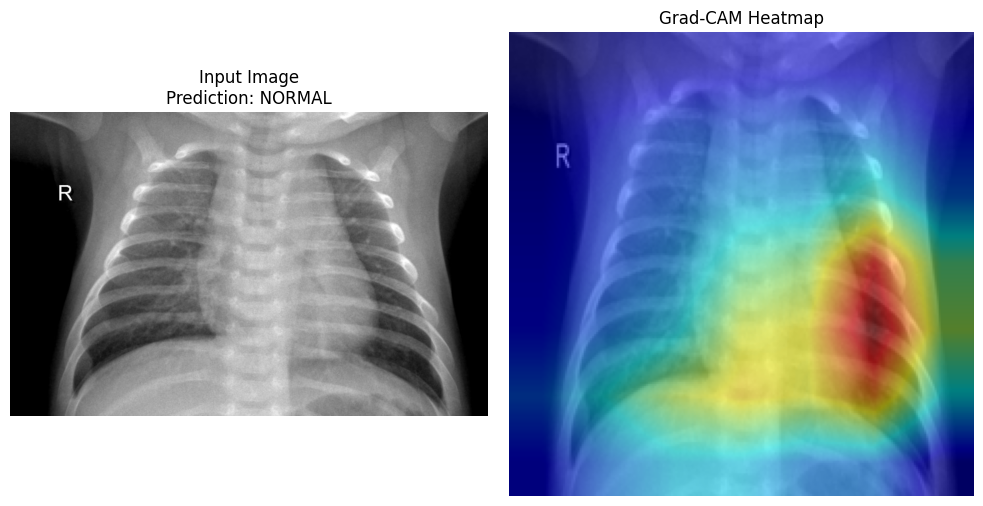


✅ Final Prediction: NORMAL


In [38]:
img_path = next(iter(uploaded))
pred = predict_with_gradcam(img_path, model, target_layer=model.layer4[-1])
print(f"\n✅ Final Prediction: {pred}")
